https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [1]:
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

import wordninja

In [2]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [3]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [4]:
pre1['split_words']=pre1['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower()))

from genderizer.genderizer import Genderizer
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

def helper(X):
    tmp = list(map(d.get_gender, X))
    tmp = [i for i in tmp if i!='unknown']
    try:
        tmp[0]
        if len(tmp)>1:
            m=0
            f=0
            for i in tmp:
                if i in ['male','mostly_male','andy']:
                    m+=1
                elif i in ['female','mostly_female']:
                    f+=1
            if m>=f:
                return 'male'
            else:
                return 'female'
        else:
            if tmp[0] in ['male','mostly_male','andy']:
                    return 'male'
            else:
                return 'female'
    except:
        return 'unknow'
    
pre1['username_split_predict'] = pre1['split_words'].apply(helper)
pre1 = pre1.drop(['split_words'],axis=1)
pre1.tail()

,username,fname.gender,username_split_predict
121328,gewens,male,male
121329,Alexa77,female,female
121330,ilmanen,female,male
121332,xmonika,female,female
121333,lidsoft,male,unknow


In [5]:
def name_count(name):
    arr = np.zeros(52+26*26+3)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in xrange(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
        # Last character
        arr[-3] = ord(name[-1])-ord('a')
        # Second Last character
        arr[-2] = ord(name[-2])-ord('a')
    # Length of name
    arr[-1] = len(name)
    return arr

In [6]:
52+26*26+3

731

In [7]:
%%time
pre1 =pre1.reset_index(drop=True)

pre1['mock_name']= pre1['username'].apply(lambda x: ''.join([i.lower() for i in str(x) if i.isdigit()==False]))
list_list =np.array(map(name_count, pre1['mock_name']))
print list_list.shape
tmp = pd.DataFrame(data=list_list, columns=['feature_'+str(i) for i in range(731)])
print tmp.shape
tmp.head(1)

(49260, 731)
(49260, 731)
CPU times: user 1.02 s, sys: 158 ms, total: 1.18 s
Wall time: 1.18 s


In [8]:
# %%time
# print cross_val_score(RandomForestClassifier(), tmp, pre0['fname.gender'], cv=10)

In [9]:
# name_count('abcdfaa')

In [10]:
# tmp = pd.DataFrame(data=name_count('abcdfaa').reshape(1,-1), columns=['feature_'+str(i) for i in range(731)])
# tmp

In [11]:
pre1.shape

(49260, 4)

In [12]:
pre1.head()

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,male,okbookman
3,revitupmedia,male,unknow,revitupmedia
4,sakshiinfosys,male,male,sakshiinfosys


In [13]:
# pre0.head()

In [14]:
%%time
def add_features(df):
    
    df['first.last'] = df['username'].str[0].str.lower()+df['username'].str[-1]
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
    df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0].str.lower()
    df['first2']= df['username'].str[:2]
    df['first3']= df['username'].str[:3]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    df['first_is_vowel'] = df['username'].apply(lambda x: str(x)[0] in 'aeiouy')
    df['last_is_digit'] = df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['first_is_digit'] = df['username'].apply(lambda x: str(x)[0].isdigit())
    df['digits.num'] = df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)]))
    df['upper.pct'] = df['username'].apply(lambda x: sum([i.isupper() for i in str(x)]))
    df['first_is_upper'] = df['username'].apply(lambda x: str(x)[0].isupper())
    df.pop('mock_name')
    
    
    

    
pre0=pre1.copy()

add_features(pre0)

pre0 = pd.concat([pre0, tmp], axis=1)

print pre0.shape

(49260, 751)
CPU times: user 623 ms, sys: 52 ms, total: 675 ms
Wall time: 671 ms


In [15]:
pre0.head(1)

,username,fname.gender,username_split_predict,first.last,last,last_two,last_three,first,first2,first3,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,bn,n,on,ion,b,b,bi,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [16]:
pre0.head()

,username,fname.gender,username_split_predict,first.last,last,last_two,last_three,first,first2,first3,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,bn,n,on,ion,b,b,bi,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,at,t,ft,oft,a,A,Ar,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,male,on,n,an,man,o,o,ok,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,ra,a,ia,dia,r,r,re,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,ss,s,ys,sys,s,s,sa,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [17]:
pre0.to_csv('./preprocessed2.csv', index=False)

In [18]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [19]:
# print pre0.columns.values
print pre0.columns.values[2:9]
pre0.head()

['username_split_predict' 'first.last' 'last' 'last_two' 'last_three'
 'first' 'first2']


,username,fname.gender,username_split_predict,first.last,last,last_two,last_three,first,first2,first3,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,bn,n,on,ion,b,b,bi,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,at,t,ft,oft,a,A,Ar,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,male,on,n,an,man,o,o,ok,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,ra,a,ia,dia,r,r,re,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,ss,s,ys,sys,s,s,sa,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [20]:
pre0.head()

,username,fname.gender,username_split_predict,first.last,last,last_two,last_three,first,first2,first3,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,bn,n,on,ion,b,b,bi,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,at,t,ft,oft,a,A,Ar,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,male,on,n,an,man,o,o,ok,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,ra,a,ia,dia,r,r,re,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,ss,s,ys,sys,s,s,sa,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [26]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:10]
label_encode(pre0, to_be_encoded_cols)


CPU times: user 106 ms, sys: 2 ms, total: 108 ms
Wall time: 109 ms


In [27]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1])
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 749), (34482,), (14778, 749), (14778,)]


,username_split_predict,first.last,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
42516,2,35,36,878,5364,0,0,39,10,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0


In [28]:
# pre0.to_csv('preprocessed.csv',index=False)

In [29]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [30]:
%%time
fr=RandomForestClassifier()
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3.28 s, sys: 138 ms, total: 3.42 s
Wall time: 3.42 s


0.819935038571
0.815536608472
Confusion matrix, without normalization
[[  378  2283]
 [  443 11674]]


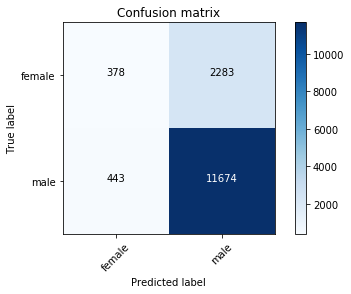

In [31]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [32]:
%%time
fr=RandomForestClassifier(n_estimators=150, min_samples_split=5, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 50.6 s, sys: 350 ms, total: 51 s
Wall time: 4.18 s


0.819935038571
0.831100284206
Confusion matrix, without normalization
[[  202  2459]
 [   37 12080]]


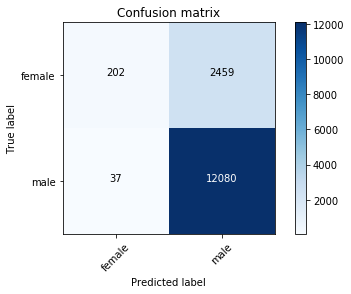

In [33]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [34]:
%%time
fr=RandomForestClassifier(n_estimators=6400, min_samples_split=6, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 35min 6s, sys: 7.01 s, total: 35min 13s
Wall time: 1min 40s


0.819935038571
0.829679252944
Confusion matrix, without normalization
[[  172  2489]
 [   28 12089]]


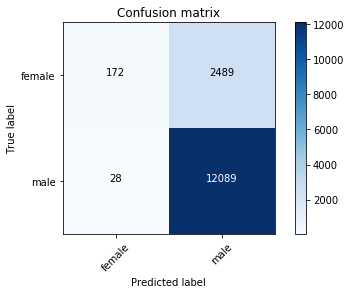

In [35]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [36]:
def plotting(model, df, num):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="g", xerr=std[indices][:num], 
            align="center", alpha=.7)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(df.shape[1]):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))

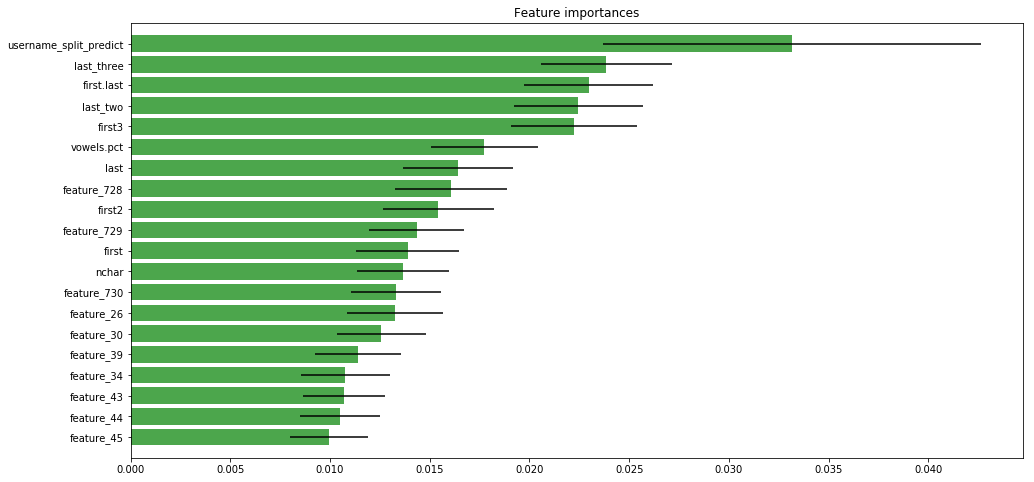

Feature ranking:
1. feature username_split_predict (3.32 %)
2. feature last_three (2.39 %)
3. feature first.last (2.30 %)
4. feature last_two (2.25 %)
5. feature first3 (2.22 %)
6. feature vowels.pct (1.77 %)
7. feature last (1.64 %)
8. feature feature_728 (1.61 %)
9. feature first2 (1.54 %)
10. feature feature_729 (1.43 %)
11. feature first (1.39 %)
12. feature nchar (1.37 %)
13. feature feature_730 (1.33 %)
14. feature feature_26 (1.33 %)
15. feature feature_30 (1.26 %)
16. feature feature_39 (1.14 %)
17. feature feature_34 (1.08 %)
18. feature feature_43 (1.07 %)
19. feature feature_44 (1.05 %)
20. feature feature_45 (1.00 %)
21. feature feature_37 (0.96 %)
22. feature feature_40 (0.93 %)
23. feature digits.pct (0.89 %)
24. feature feature_28 (0.83 %)
25. feature feature_38 (0.80 %)
26. feature feature_29 (0.74 %)
27. feature feature_33 (0.73 %)
28. feature feature_0 (0.68 %)
29. feature feature_27 (0.68 %)
30. feature feature_32 (0.65 %)
31. feature feature_36 (0.64 %)
32. feature 

In [37]:
plotting(fr, X_train, 20)

In [112]:
RandomForestClassifier?

In [38]:
%%time
fr=RandomForestClassifier(n_estimators=200
                          , min_samples_split=6, n_jobs=24, criterion='entropy')
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 1min 3s, sys: 358 ms, total: 1min 3s
Wall time: 4.87 s


0.819935038571
0.830558938963
Confusion matrix, without normalization
[[  192  2469]
 [   35 12082]]


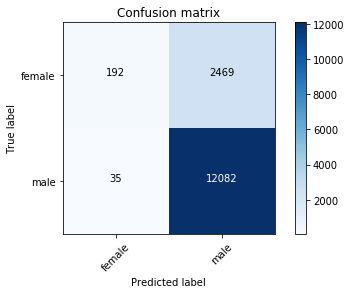

In [39]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [40]:
RandomForestClassifier?

In [152]:
print 12117/14778.0

0.819935038571


In [27]:
%%time
fr=RandomForestClassifier(n_estimators=102400, min_samples_split=6, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 8h 57min 23s, sys: 1min 26s, total: 8h 58min 50s
Wall time: 25min 25s


0.819935038571
0.827581540127
Confusion matrix, without normalization
[[  119  2542]
 [    6 12111]]


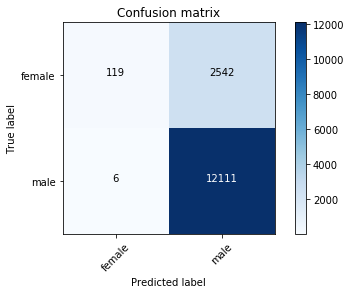

In [28]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [30]:
SVC?

https://stackoverflow.com/questions/9299346/fastest-svm-implementation-usable-in-python

In [ ]:
%%time
svm=SVC()
svm.fit(X_train, y_train)
## predict labels
svm_p = svm.predict(X_test)
pd.Series(svm_p).value_counts()

0.819935038571
0.818040330221
Confusion matrix, without normalization
[[   80  2581]
 [  108 12009]]


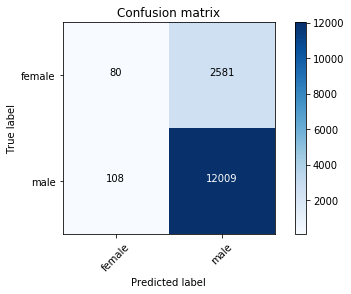

In [34]:
print 12117/14778.0
print accuracy_score(y_test, svm_p)
plot_confusion_matrix(confusion_matrix(y_test,svm_p), ['female','male'])

0.818378670997
Confusion matrix, without normalization
[[   10  2651]
 [   33 12084]]


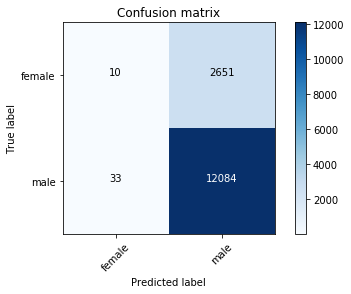

CPU times: user 8.47 s, sys: 2.4 s, total: 10.9 s
Wall time: 8.31 s


In [41]:
%%time
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm_pr=lsvm.predict(X_test)
pd.Series(lsvm_pr).value_counts()
print accuracy_score(y_test, lsvm_pr)
plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [106]:
confusion_matrix(y_test,fr_p)

array([[  202,  2459],
       [   23, 12094]])

In [108]:
# d_train.get_label()

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [42]:
import xgboost as xgb

/home/shj16110/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

In [44]:
d_train.get_label()

array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

In [45]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [46]:
def female_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    cof = confusion_matrix(y, tmp)
    g_f_c = cof[0][0]
    b_f_c = cof[1][0]
    r_f_c = cof[0][1]
    target = (g_f_c - 1.1*b_f_c)/float(r_f_c)
    return 'female_acc',target
    

In [47]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=female_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-female_acc:0.185553	test-female_acc:-0.147239
Multiple eval metrics have been passed: 'test-female_acc' will be used for early stopping.

Will train until test-female_acc hasn't improved in 100 rounds.
[20]	train-female_acc:0.317771	test-female_acc:0.035229
[40]	train-female_acc:0.494245	test-female_acc:0.044653
[60]	train-female_acc:0.831966	test-female_acc:0.058629
[80]	train-female_acc:1.34475	test-female_acc:0.068159
[100]	train-female_acc:2.10756	test-female_acc:0.070873
[120]	train-female_acc:3.3825	test-female_acc:0.077324
[140]	train-female_acc:5.60638	test-female_acc:0.080996
[160]	train-female_acc:9.21382	test-female_acc:0.079567
[180]	train-female_acc:14.9231	test-female_acc:0.078531
[200]	train-female_acc:24.875	test-female_acc:0.079913
[220]	train-female_acc:40.1258	test-female_acc:0.077457
[240]	train-female_acc:78.6154	test-female_acc:0.075109
[260]	train-female_acc:131.128	test-female_acc:0.077438
Stopping. Best iteration:
[178]	train-female_acc:14.4094	test-f

'!!! used 90.95 s'

accuracy 0.833265665178
statistic
male      14225
female      553
dtype: int64
Confusion matrix, without normalization
[[  375  2286]
 [  178 11939]]


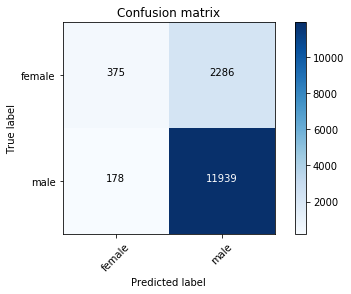

In [48]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

accuracy 0.835363377994


#### on accuracy 

### tune

In [ ]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [175]:
y_train.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64

In [186]:
6210.0/28272

0.21965195246179967

In [55]:
RANDOM_STATE = 2017

params = {
    'min_child_weight': 0.8,
#     'eta': 0.1,
    'colsample_bytree': 0.8,
    'max_depth': 28,
    'subsample': 0.8,
    'alpha': 2,
    'lambda':3,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12,
        'max_delta_step ':7,
        'colsample_bylevel ':0.9 ,    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [56]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=500, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.835276	test-acc:0.823048
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 500 rounds.
[20]	train-acc:0.842063	test-acc:0.826431
[40]	train-acc:0.843165	test-acc:0.826364
[60]	train-acc:0.843919	test-acc:0.826431
[80]	train-acc:0.844499	test-acc:0.826093
[100]	train-acc:0.845949	test-acc:0.82677
[120]	train-acc:0.847428	test-acc:0.827379
[140]	train-acc:0.848878	test-acc:0.827785
[160]	train-acc:0.849545	test-acc:0.828055
[180]	train-acc:0.850647	test-acc:0.828394
[200]	train-acc:0.851865	test-acc:0.828597
[220]	train-acc:0.853692	test-acc:0.829206
[240]	train-acc:0.854591	test-acc:0.82907
[260]	train-acc:0.856244	test-acc:0.829476
[280]	train-acc:0.857868	test-acc:0.829815
[300]	train-acc:0.860159	test-acc:0.830288
[320]	train-acc:0.862247	test-acc:0.830491
[340]	train-acc:0.864741	test-acc:0.830627
[360]	train-acc:0.867264	test-acc:0.831168
[380]	train-acc:0.870019	test-acc:0.830965
[400]	

'!!! used 367.96 s'

accuracy 0.833739342266
statistic
male      14212
female      566
dtype: int64
Confusion matrix, without normalization
[[  385  2276]
 [  181 11936]]


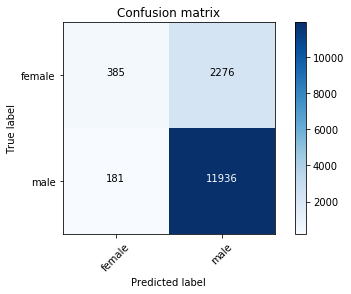

In [57]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [50]:
f_ip = pd.DataFrame(clf.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
f_ip.head(10)

,feature,importance
451,last_three,12671
257,first.last,11558
133,last_two,9577
261,first3,8544
333,vowels.pct,7594
389,last,6032
392,nchar,5023
480,feature_728,4952
491,feature_30,4687
479,feature_729,4585


In [54]:
# pd.DataFrame.plot?

# accuracy 0.836175395859
# statistic
# male      14190
# female      588
# dtype: int64
# Confusion matrix, without normalization
# [[  414  2247]
#  [  174 11943]]

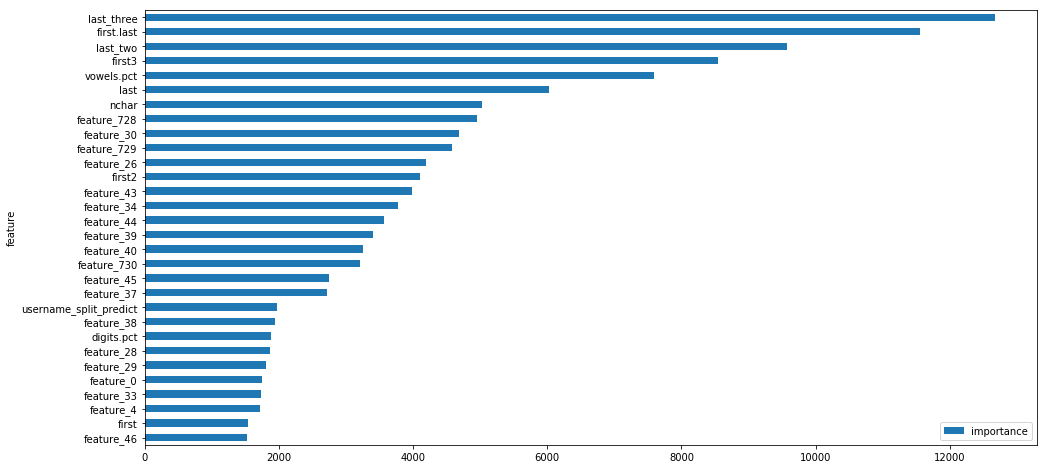

In [51]:
f_ip.head(30).iloc[::-1].set_index('feature').plot(kind='barh', figsize=(16,8))
plt.show()

In [120]:
pre0 = pre1.copy()
pre0.head(3)

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,male,okbookman


### other sklearn models

In [270]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()
# print accuracy_score(y_test, lsvm_pr)
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [110]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [140]:
# svm = SVC()
# svm

In [141]:
# %%time
# # svm.fit(X_train, y_train)

In [142]:
# from sklearn.neural_network import MLPClassifier

In [143]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [145]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [146]:
# pd.Series(neur_prd).value_counts()

In [147]:
# accuracy_score(y_test,neur_prd)

In [148]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [156]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [157]:
# pd.Series(pred).value_counts()

In [158]:
# accuracy_score(y_test, pred)

In [159]:
# confusion_matrix(y_test,pred)

In [161]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [149]:
# from sklearn.naive_bayes import BernoulliNB

In [150]:
# nb = BernoulliNB()
# nb

In [162]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()